Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

#Import and Wrangle

In [15]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [16]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv',
                 parse_dates=['Date'],
                 index_col='Date')

In [17]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [18]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood', 'Mass (g)', 'Density (g/mL)', 'Unreliable', 'NonSD'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [19]:
print(df.shape)
df.head(5)

(421, 66)


,Location,Burrito,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,Donato's taco shop,California,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Oscar's Mexican food,California,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Oscar's Mexican food,Carnitas,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Oscar's Mexican food,Asada,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-27,Pollos Maria,California,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
## Check for null values or any other removable columns
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 54 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Burrito        421 non-null    object 
 1   Yelp           87 non-null     float64
 2   Google         87 non-null     float64
 3   Chips          26 non-null     object 
 4   Cost           414 non-null    float64
 5   Hunger         418 non-null    float64
 6   Length         283 non-null    float64
 7   Circum         281 non-null    float64
 8   Volume         281 non-null    float64
 9   Tortilla       421 non-null    float64
 10  Temp           401 non-null    float64
 11  Meat           407 non-null    float64
 12  Fillings       418 non-null    float64
 13  Meat:filling   412 non-null    float64
 14  Uniformity     419 non-null    float64
 15  Salsa          396 non-null    float64
 16  Synergy        419 non-null    float64
 17  Wrap           418 non-null    floa

In [9]:
## Assuming all ingredients columns have an X meaning included and a NaN for not included
## Change all X's to 1's and NaN's to 0's
for col in list(df.columns[18:53]):
  df[col] = [1 if val=='X' or val=='x' else 0 for val in df[col]]

In [10]:
## We can use an imputer on Yelp, Google, etc.
## Change Chips col like the others
df['Chips'] = [1 if val=='X' or val=='x' else 0 for val in df['Chips']]

In [11]:
## Test column counts to df.info() above
df['Onion'].value_counts()

0    404
1     17
Name: Onion, dtype: int64

In [12]:
## All the rest of the columns can be filled by the imputer
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 54 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Burrito        421 non-null    object 
 1   Yelp           87 non-null     float64
 2   Google         87 non-null     float64
 3   Chips          421 non-null    int64  
 4   Cost           414 non-null    float64
 5   Hunger         418 non-null    float64
 6   Length         283 non-null    float64
 7   Circum         281 non-null    float64
 8   Volume         281 non-null    float64
 9   Tortilla       421 non-null    float64
 10  Temp           401 non-null    float64
 11  Meat           407 non-null    float64
 12  Fillings       418 non-null    float64
 13  Meat:filling   412 non-null    float64
 14  Uniformity     419 non-null    float64
 15  Salsa          396 non-null    float64
 16  Synergy        419 non-null    float64
 17  Wrap           418 non-null    floa

#Split

In [10]:
## Split data into Train/Test/Validate
dfs = []

dfs.append(df[df.index.year <= 2016])
dfs.append(df[df.index.year == 2017])
dfs.append(df[df.index.year >= 2018])

In [11]:
## Further split data into target vectors and feature matrices
target = 'Great'

def split_data(dfs):
  return dfs.drop(columns=target), dfs[target]

X_train, y_train = split_data(dfs[0])
X_val, y_val = split_data(dfs[1])
X_test, y_test = split_data(dfs[2])

In [12]:
assert len(X_train) + len(X_val) + len(X_test) == len(df)

#Baseline

In [16]:
## To create basline, are more burritos great or not?
y_train.value_counts()

False    176
True     122
Name: Great, dtype: int64

In [17]:
## More burritos are NOT great, so that will be our baseline.
print('Baseline Accuracy:', str(round(y_train.value_counts(normalize=True).max()*100, 2)) + '%')

Baseline Accuracy: 59.06%


In [18]:
## We would have about a 60% chance of predicting correctly that a burrito would NOT be great

#Build Model

In [19]:
## Check head to choose transformers if needed.
df.head()

,Burrito,Yelp,Google,Chips,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,California,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2016-01-24,California,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2016-01-24,Carnitas,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2016-01-24,Asada,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2016-01-27,California,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True


In [20]:
## Due to NaN values, we will need Imputer; need an Encoder for 'Burrito' type; Scaler for standardization
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

model.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


#Check Metrics

In [22]:
print('Training Accuracy:', str(round(model.score(X_train, y_train)*100, 2)) + '%')

Training Accuracy: 93.62%


In [23]:
print('Validation Accuracy:', str(round(model.score(X_val, y_val)*100, 2)) + '%')

Validation Accuracy: 75.29%


In [24]:
print('Test Accuracy:', str(round(model.score(X_test, y_test)*100, 2)) + '%')

Test Accuracy: 73.68%


#Visualizations

In [25]:
## Look at each pipeline step
model.steps

[('onehotencoder',
  OneHotEncoder(cols=['Burrito'], drop_invariant=False, handle_missing='value',
                handle_unknown='value', return_df=True, use_cat_names=True,
                verbose=0)),
 ('simpleimputer',
  SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                missing_values=nan, strategy='mean', verbose=0)),
 ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('logisticregression',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False))]

In [26]:
## Assign each model step to a variable to access parameters later
def params():
  steps = []
  for i in range(0, len(model.steps)):
    steps.append(model.steps[i][1])

  return steps

ohe, imp, scale, lr = params()

In [51]:
## To graph importance of features, retrieve column names and corresponding coefficients
coefficients = lr.coef_[0]
col_names = ohe.get_feature_names()

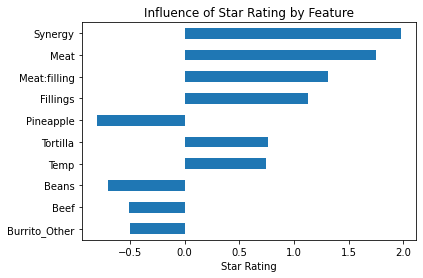

In [54]:
import matplotlib.pyplot as plt

feat_imp = pd.Series(data=coefficients, index=col_names)
feat_imp.sort_values(key=lambda x: abs(x), inplace=True) # Sort values by absolute value so strength is shown and not pos/neg
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Star Rating')
plt.title('Influence of Star Rating by Feature')
plt.show()

##Conclusions:

- By the means of my model, Synergy has the strongest influence in someone deciding whether a burrito is great (a 4-star rating or higher) or not.

- This means that a high level of flavor synergy in a burrito can cause nearly a 2-star positive shift in someone's overall burrito rating.

- Where's the beef!? Because apparantly, that is the next most crucial topic.

- Relating to metrics, our model fit the training data extremely well, but lowered once it was introduced to the validation data. It countinued to lower just a tad more when predicting for test data.
